In [119]:
from astropy.table import Table, vstack, Column, MaskedColumn, pprint
import numpy as np

import matplotlib 
import matplotlib.pyplot as plt
from astropy.convolution import convolve, Gaussian1DKernel

from astropy.io import fits
from matplotlib.backends.backend_pdf import PdfPages

import os
import requests
import sys
sys.path.append('/Users/s2537809/DESI/desispec/py')
sys.path.append('/Users/s2537809/DESI/desimodel/py')
sys.path.append('/Users/s2537809/DESI/desitarget/py')
sys.path.append('/Users/s2537809/DESI/desiutil/py')

#from desispec.io import read_spectra
# import DESI related modules - 
from desimodel.footprint import radec2pix      # For getting healpix values
import desispec.io                             # Input/Output functions related to DESI spectra
from desispec import coaddition                # Functions related to coadding the spectra


from scipy import interpolate
import astropy.units as u
path='/Users/s2537809/Documents/DESI-STACKING'#specify code directory
os.chdir(path)
import stack_code as sc
import importlib
import fnmatch
import extinction as ext
from scipy.optimize import curve_fit
from astropy.coordinates import SkyCoord
from astropy.modeling import models
from astropy.table import Table
from matplotlib import gridspec
import spectres
import time
import warnings

#pip install lmfit, extinction, sfdmap, spectres

import pandas as pd
crossmatch = Table.read('crossmatch_classifications.fits', format = 'fits' )

In [120]:
""" 
Remove the objects with failed redshfit classifications.
First appplying their ZWARN flag, then with the photo-z quality flag.
"""

# Apply ZWARN Flag cut
crossmatch = crossmatch[crossmatch['ZWARN'] == 0]

# Create photo-z quality flag
crossmatch['Z_CHECK']= (crossmatch['Z']-crossmatch['Z_BEST_1'])/(1+crossmatch['Z'])
crossmatch['Z_FAILURE'] = 0  
crossmatch['Z_FAILURE'][abs(crossmatch['Z_CHECK']) > 0.1] = 1 

# Apply photo-z quality flag
crossmatch = crossmatch[crossmatch['Z_FAILURE'] == 0]
print(len(crossmatch))
print(len(crossmatch[crossmatch['Z'] < 0]))


7533
27


## Cell below verifies if Spectra are downloaded and downloads if they aren't

Only run if unsure if spectra are downloaded, to save time!

In [2]:
"""
Note: The lengths for indexing are:

HERG = 184

RQAGN = 814

LERG = 1293

SFG = 6294

Note: NEW lengths for indexing are:

HERG = 136

RQAGN = 595

LERG = 1188

SFG = 5547

"""


Overall_class = 'SFG'
my_table = crossmatch[crossmatch['Overall_class'] == f'{Overall_class}'][1000:1200]
search_column_name = 'TARGETID'
search_values = np.array(my_table[f'{search_column_name}'])



def select_data(table, column_name, search_values):
    # Get the column data as a numpy array
    column_data = table[column_name]

    SURVEY = []
    PROGRAM = []
    HEALPIX = []
    n_values = []
    Z = []
    

    for search_value in search_values:
        # Find the indices where the condition is met (value == search_value)
        indices = np.where(column_data == search_value)[0]


        if len(indices) > 0:
            # Find the corresponding Survey, program, healpix, and Z values
            SURVEY.append(table['SURVEY'][indices[0]])
            PROGRAM.append(table['PROGRAM'][indices[0]])
            HEALPIX.append(table['HEALPIX'][indices[0]])
            Z.append(table['Z'][indices[0]])
            HEALPIX_str = str(table['HEALPIX'][indices[0]])
            n_str = HEALPIX_str[:3]
            n_values.append(int(n_str))
        else:
            # Handle the case where the search value was not found
            SURVEY.append(None)
            PROGRAM.append(None)
            HEALPIX.append(None)
            n_values.append(None)
            Z.append(None)
    

    return np.array(SURVEY), np.array(PROGRAM), np.array(HEALPIX), np.array(n_values), np.array(Z), 


SURVEY = select_data(my_table, search_column_name, search_values)[0]
PROGRAM = select_data(my_table, search_column_name, search_values)[1]
HEALPIX = select_data(my_table, search_column_name, search_values)[2]
n = select_data(my_table, search_column_name, search_values)[3]
Z = select_data(my_table, search_column_name, search_values)[4]
print (SURVEY,PROGRAM,HEALPIX, n, Z)

for n, survey, program, healpix, Z, search_value in zip(n, SURVEY, PROGRAM, HEALPIX, Z, search_values):
        #download the file from the given Target ID
        target_url = f"https://data.desi.lbl.gov/public/edr/spectro/redux/fuji/healpix/{survey}/{program}/{n}/{healpix}/coadd-{survey}-{program}-{healpix}.fits"
        
        # Define the folder name and file name
        folder_name = 'DESI_Downloads'
        file_name = f"coadd-{survey}-{program}-{healpix}.fits"
        print(search_value)


        # Check if the folder exists, and create it if it doesn't
        if not os.path.exists(folder_name):
            os.makedirs(folder_name)

        # Check if the file exists in the folder
        file_path = os.path.join(folder_name, file_name)
        if os.path.exists(file_path):
            print(f"{file_name} already exists in {folder_name}. No need to download.")
        else:
            # File doesn't exist, download it
            try:
                response = requests.get(target_url)
                if response.status_code == 200:
                    with open(file_path, 'wb') as file:
                        file.write(response.content)
                    print(f"{file_name} downloaded to {folder_name}.")
                else:
                    print(f"Failed to download {file_name}. Status code: {response.status_code}")
            except Exception as e:
                print(f"An error occurred while downloading {file_name}: {str(e)}")

      

['sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv1' 'sv3' 'sv3'
 'sv3' 'sv1' 'sv1' 'sv3' 'sv3' 'sv3' 'sv1' 'sv1' 'sv3' 'sv3' 'sv1' 'sv1'
 'sv3' 'sv1' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv1' 'sv1' 'sv3' 'sv1' 'sv1'
 'sv1' 'sv3' 'sv3' 'sv1' 'sv3' 'sv3' 'sv3' 'sv3' 'sv1' 'sv1' 'sv1' 'sv3'
 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv1' 'sv1' 'sv3'
 'sv3' 'sv3' 'sv3' 'sv1' 'sv1' 'sv3' 'sv1' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3'
 'sv1' 'sv3' 'sv3' 'sv1' 'sv1' 'sv1' 'sv1' 'sv1' 'sv3' 'sv1' 'sv3' 'sv3'
 'sv1' 'sv3' 'sv3' 'sv3' 'sv1' 'sv1' 'sv3' 'sv1' 'sv1' 'sv3' 'sv3' 'sv1'
 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv1' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3'
 'sv1' 'sv3' 'sv1' 'sv3' 'sv3' 'sv1' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3'
 'sv1' 'sv3' 'sv1' 'sv3' 'sv3' 'sv3' 'sv1' 'sv1' 'sv3' 'sv1' 'sv1' 'sv3'
 'sv1' 'sv3' 'sv3' 'sv1' 'sv3' 'sv3' 'sv1' 'sv3' 'sv1' 'sv1' 'sv1' 'sv3'
 'sv1' 'sv3' 'sv1' 'sv3' 'sv3' 'sv3' 'sv1' 'sv1' 'sv3' 'sv3' 'sv3' 'sv3'
 'sv1' 'sv1' 'sv3' 'sv3' 'sv3' 'sv3' 'sv1' 'sv3' 's

In [121]:
def inv_var_weighted_average(flux1, ivar1, flux2, ivar2):
    """
    Finds the inverse varience weighted average of two flux spectra
    
    """
    weight1 = 1 / ivar1
    weight2 = 1 / ivar2
    total_weight = weight1 + weight2
    weighted_flux1 = flux1 * (weight1 / total_weight)
    weighted_flux2 = flux2 * (weight2 / total_weight)
    weighted_avg = weighted_flux1 + weighted_flux2
    return weighted_avg

def no_overlap_f(waveb,fluxb,waver,fluxr,wavez,fluxz):
    """
    Isolates the flux and wavelength arrays of each band to non-overlapping wavelength sections
    
    """
    new_b_length = np.where(waveb<waver[0])
    b_wave = waveb[new_b_length]
    b_flux = fluxb[new_b_length]
    new_r_length = np.where((waver>waveb[-1])&(waver<wavez[0]))
    r_wave = waver[new_r_length]
    r_flux = fluxr[new_r_length]
    new_z_length = np.where(wavez>waver[-1])
    z_wave = wavez[new_z_length]
    z_flux = fluxz[new_z_length]

    return b_wave,b_flux,r_wave,r_flux,z_wave,z_flux


def overlap_av(wave1,wave2,flux1,flux2,ivar1,ivar2):
    """
    Finds the overlap of two wavelength ranges.
    Computes the inverse var weighted average flux and wavelength for th eoverlapping range 
    
    """
    overlap_idx_1 = np.where(wave1 >= wave2[0]) 
    overlap_wave = wave1[overlap_idx_1]
    overlap_flux_1 = flux1[overlap_idx_1]
    overlap_ivar_1 = ivar1[overlap_idx_1]

    overlap_idx_2 = np.where(wave2 <= wave1[-1]) 
    overlap_flux_2 = flux2[overlap_idx_2]
    overlap_ivar_2 = ivar2[overlap_idx_2]
    
    overlap_av_flux = inv_var_weighted_average(overlap_flux_1,overlap_ivar_1,overlap_flux_2,overlap_ivar_2)

    return overlap_av_flux, overlap_wave

def resample_col(wave_bound, z_bound):
    """
    The spectra are resampled onto a common grid in the stacking process.
    This gives the resampled rest-frame colour boundaries for plotting.

    """
    wave_rest = wave_bound / (1+z_bound)

    return wave_rest

In [122]:
#stacking functions


# Ignore warnings due to spec_var=0
warnings.filterwarnings("ignore", message="divide by zero encountered in true_divide")


def get_spectra(table, column_name, search_values): 
    print('Number of spectra =', len(table))
    # Get the Target IDs as a numpy array
    column_data = table[column_name]

    SURVEY, PROGRAM, HEALPIX, n_values = [], [], [], []
    Z, RA, DEC, Source_ID = [], [], [], []


    for search_value in search_values:
        # Find the indices where the condition is met (value == search_value)
        # This is only relevant if input is doen by search value and not selected table
        indices = np.where(column_data == search_value)[0]

        if len(indices) > 0:
            # Find the corresponding Survey, program, healpix, Z , RA and Dec values
            SURVEY.append(table['SURVEY'][indices[0]])
            PROGRAM.append(table['PROGRAM'][indices[0]])
            HEALPIX.append(table['HEALPIX'][indices[0]])
            Z.append(table['Z'][indices[0]])
            RA.append(table['TARGET_RA'][indices[0]]) 
            DEC.append(table['TARGET_DEC'][indices[0]])
            Source_ID.append(table['TARGETID'][indices[0]])
            HEALPIX_str = str(table['HEALPIX'][indices[0]])
            n_str = HEALPIX_str[:3]
            n_values.append(int(n_str))
        else:
            # Handle the case where the search value was not found
            SURVEY.append(None)
            PROGRAM.append(None)
            HEALPIX.append(None)
            n_values.append(None)
            Z.append(None)   
            RA.append(None)
            DEC.append(None)
            Source_ID.append(None)
            
    
    z = np.array(Z)
    RA = np.array(RA)
    DEC = np.array(DEC)
    id_spec = np.array(Source_ID)
    wave_spec, flux_spec, sigma_spec = [], [], []
    b_end, r_start, r_end, z_start = [], [], [], []
    
    for index, (survey, program, healpix, search_value) in enumerate(zip(SURVEY, PROGRAM, HEALPIX, search_values)):
        
        folder_name = 'DESI_Downloads'
        file_name = f"coadd-{survey}-{program}-{healpix}.fits"
        coadd_obj = desispec.io.read_spectra(f'{folder_name}/{file_name}')
        coadd_tgts = coadd_obj.target_ids().data
        # Selecting the particular spectra of the targetid
        row = (coadd_tgts == search_value)
        coadd_spec = coadd_obj[row] 

        # Inverse Vartiance weighted average for overlap
        no_overlap = no_overlap_f(coadd_spec.wave['b'],coadd_spec.flux['b'][0],coadd_spec.wave['r'],coadd_spec.flux['r'][0],coadd_spec.wave['z'],coadd_spec.flux['z'][0])
        overlap_br= overlap_av(coadd_spec.wave['b'],coadd_spec.wave['r'],coadd_spec.flux['b'][0],coadd_spec.flux['r'][0],coadd_spec.ivar['b'][0],coadd_spec.ivar['r'][0])
        overlap_rz= overlap_av(coadd_spec.wave['r'],coadd_spec.wave['z'],coadd_spec.flux['r'][0],coadd_spec.flux['z'][0],coadd_spec.ivar['r'][0],coadd_spec.ivar['z'][0])
        
        # Prnt the resampled rest-frame wavelength boundaries
        b_start = resample_col(coadd_spec.wave['b'][0],z)
        b_end1 = resample_col(coadd_spec.wave['b'][-1],z) 
        r_start1 = resample_col(coadd_spec.wave['r'][0],z)
        r_end1 = resample_col(coadd_spec.wave['r'][-1],z)
        z_start1 = resample_col(coadd_spec.wave['z'][0],z)
        z_end = resample_col(coadd_spec.wave['z'][-1],z)
        #print('range 1:', coadd_spec.wave['z'][-1]-coadd_spec.wave['b'][0])
        #print('range new:', z_end-b_start)
        #print('B start 1:',coadd_spec.wave['b'][0],'B end 1:', coadd_spec.wave['b'][-1],'R start 1:', coadd_spec.wave['r'][0], 'R end 1:', coadd_spec.wave['r'][-1], 'Z start', coadd_spec.wave['z'][0], 'Z end', coadd_spec.wave['z'][-1])
        #print('B start:',b_start,'B end:', b_end,'R start:', r_start, 'R end:', r_end, 'Z start:', z_start, 'Z end:', z_end)
        b_end.append(b_end1)
        r_start.append(r_start1)
        r_end.append(r_end1)
        z_start.append(z_start1)
        

        
        # Concaternating Spectra
        flux_spectra = np.concatenate((no_overlap[1],overlap_br[0],no_overlap[3],overlap_rz[0],no_overlap[5]))
        wave_spectra = np.concatenate((no_overlap[0],overlap_br[1],no_overlap[2],overlap_rz[1],no_overlap[4]))

        # Using Desispec to get wavelengths, flux and sigma
        wave = wave_spectra
        wave = wave.flatten()
        #flux = coadd_spec.flux['r'][0]
        #flux = convolve(flux_spectra, Gaussian1DKernel(5))
        #pick if i want to convolve or not
        flux = flux_spectra
        flux = flux.flatten()
        sigma = (np.sqrt(1/coadd_spec.ivar['r']))
        sigma = sigma.flatten()
        if index % 2 == 0 and len(wave) > 0:
                wave = wave[:-1]
                flux = flux[:-1]
                sigma = sigma[:-1]
        sigma_spec.append(sigma)
        wave_spec.append(wave)
        flux_spec.append(flux)
        
    
    wave_spec = np.array(wave_spec,dtype=object)
    flux_spec = np.array(flux_spec,dtype=object)
    sigma_spec = np.array(sigma_spec,dtype=object)
    # alternatively tried wave_spec = wave_spec.tolist()
   

    return wave_spec, flux_spec, sigma_spec, z, RA, DEC, id_spec


def get_stack(spec, zbins=None):# can add redshift ranges i.e zbins = [[0.0,0.1],[0.1,0.2]]
    wave_spec, flux_spec, sigma_spec, z, RA, DEC, id_spec= spec
    stack = sc.stack_spectra(wave_spec,flux_spec,sigma_spec,
                               z, RA, DEC, zbins = zbins)
    return stack

## Spectra Selection and Application of Stacking

In [143]:

"""

Redshift binning and stacking to a csv file 


"""

# Select varibale to sort by
#Mass_median or Total_flux from LOFAR?

#var_bin = 'Mass_median'
#crossmatch = crossmatch[np.array(np.argsort(crossmatch[f'{var_bin}']))]

Overall_class = 'HERG'
my_table = crossmatch[crossmatch['Overall_class'] == f'{Overall_class}'][0:136]
search_column_name = 'TARGETID'

tble_1 = crossmatch[(crossmatch['Z']>0.03) & (crossmatch['Z'] < 0.4)]
my_table_1 = tble_1[tble_1['Overall_class'] == f'{Overall_class}'][0:136]
tble_2 = crossmatch[(crossmatch['Z']>0.4) & (crossmatch['Z'] < 0.9)]
my_table_2 = tble_2[tble_2['Overall_class'] == f'{Overall_class}'][0:136]
tble_3 = crossmatch[(crossmatch['Z']>0.9) & (crossmatch['Z'] < 1.6)] #1.6 as this is where redrock starts to fail
my_table_3 = tble_3[tble_3['Overall_class'] == f'{Overall_class}'][0:136]

tables = [my_table, my_table_1, my_table_2, my_table_3]
stacks = []

for table in tables:
    search_values = np.array(table[f'{search_column_name}'])
    spec = get_spectra(table, search_column_name, search_values)
    stack = get_stack(spec)
    stacks.append(stack)

# Save stacks to CSV
for i, stack in enumerate(stacks):
    stack_df = pd.DataFrame({'wave_spec': stack['zbin=0']['wln'], 'flux_spec': stack['zbin=0']['flux']})
    stack_df.to_csv(f'{Overall_class}_stack_{i}.csv', index=False)
    print(f'Saved {Overall_class}_stack_{i}.csv')





Number of spectra = 136
INFO:spectra.py:372:read_spectra: iotime 1.955 sec to read coadd-sv3-dark-11520.fits at 2024-01-30T09:05:49.558152
INFO:spectra.py:372:read_spectra: iotime 2.004 sec to read coadd-sv3-dark-11520.fits at 2024-01-30T09:05:52.085918


/var/folders/wq/x4d7t0dd705bwvpnmkf6s7s40000gn/T/ipykernel_1380/437957867.py:6: RuntimeWarning: divide by zero encountered in divide
  weight1 = 1 / ivar1
/var/folders/wq/x4d7t0dd705bwvpnmkf6s7s40000gn/T/ipykernel_1380/437957867.py:9: RuntimeWarning: invalid value encountered in divide
  weighted_flux1 = flux1 * (weight1 / total_weight)
/var/folders/wq/x4d7t0dd705bwvpnmkf6s7s40000gn/T/ipykernel_1380/3891221526.py:98: RuntimeWarning: divide by zero encountered in divide
  sigma = (np.sqrt(1/coadd_spec.ivar['r']))


INFO:spectra.py:372:read_spectra: iotime 1.694 sec to read coadd-sv3-bright-11520.fits at 2024-01-30T09:05:55.087581
INFO:spectra.py:372:read_spectra: iotime 1.808 sec to read coadd-sv3-dark-11520.fits at 2024-01-30T09:05:57.689016
INFO:spectra.py:372:read_spectra: iotime 2.239 sec to read coadd-sv3-dark-10154.fits at 2024-01-30T09:06:00.874197
INFO:spectra.py:372:read_spectra: iotime 1.842 sec to read coadd-sv3-dark-11520.fits at 2024-01-30T09:06:03.679177


/var/folders/wq/x4d7t0dd705bwvpnmkf6s7s40000gn/T/ipykernel_1380/437957867.py:7: RuntimeWarning: divide by zero encountered in divide
  weight2 = 1 / ivar2
/var/folders/wq/x4d7t0dd705bwvpnmkf6s7s40000gn/T/ipykernel_1380/437957867.py:10: RuntimeWarning: invalid value encountered in divide
  weighted_flux2 = flux2 * (weight2 / total_weight)


INFO:spectra.py:372:read_spectra: iotime 1.785 sec to read coadd-sv3-dark-11520.fits at 2024-01-30T09:06:06.397285
INFO:spectra.py:372:read_spectra: iotime 1.795 sec to read coadd-sv3-bright-10154.fits at 2024-01-30T09:06:08.875171
INFO:spectra.py:372:read_spectra: iotime 1.934 sec to read coadd-sv3-dark-10154.fits at 2024-01-30T09:06:11.327114
INFO:spectra.py:372:read_spectra: iotime 1.677 sec to read coadd-sv3-bright-10154.fits at 2024-01-30T09:06:13.933877
INFO:spectra.py:372:read_spectra: iotime 1.926 sec to read coadd-sv3-dark-10154.fits at 2024-01-30T09:06:16.605668
INFO:spectra.py:372:read_spectra: iotime 2.577 sec to read coadd-sv3-dark-11521.fits at 2024-01-30T09:06:19.733393
INFO:spectra.py:372:read_spectra: iotime 1.916 sec to read coadd-sv3-dark-10154.fits at 2024-01-30T09:06:23.468239
INFO:spectra.py:372:read_spectra: iotime 1.683 sec to read coadd-sv3-bright-11520.fits at 2024-01-30T09:06:25.913819
INFO:spectra.py:372:read_spectra: iotime 1.882 sec to read coadd-sv3-dark-

In [169]:
"""

Reads the csv's back in 


** START HERE IF DON'T NEED TO RERUN THE STACKING CODE **



"""

Overall_class = 'HERG'
my_table = crossmatch[crossmatch['Overall_class'] == f'{Overall_class}']
search_column_name = 'TARGETID'

tble_1 = crossmatch[(crossmatch['Z']>0.03) & (crossmatch['Z'] < 0.4)]
my_table_1 = tble_1[tble_1['Overall_class'] == f'{Overall_class}']
tble_2 = crossmatch[(crossmatch['Z']>0.4) & (crossmatch['Z'] < 0.9)]
my_table_2 = tble_2[tble_2['Overall_class'] == f'{Overall_class}']
tble_3 = crossmatch[(crossmatch['Z']>0.9) & (crossmatch['Z'] < 1.6)] #1.6 as this is where redrock starts to fail
my_table_3 = tble_3[tble_3['Overall_class'] == f'{Overall_class}']

tables = [my_table, my_table_1, my_table_2, my_table_3]


print(len(tble_1), len(my_table_1))

stacks = []
wln = []
flux = []


for i in range(4):
    stack_df = pd.read_csv(f'{Overall_class}_stack_{i}.csv')
    stack = (stack_df['wave_spec'].values, stack_df['flux_spec'].values)
    wln.append(stack[0])
    flux.append(stack[1])
    stacks.append(stack)


wln_1, flux_1 = wln[1], flux[1]
wln_2, flux_2 = wln[2], flux[2]
wln_3, flux_3 = wln[3], flux[3]
wln, flux = wln[0], flux[0]

print(wln, flux)
print(wln_1, flux_1)
print(wln_2, flux_2)
print(wln_3, flux_3)



3699 35
[ 807.5  808.5  809.5 ... 9330.5 9331.5 9332.5] [nan nan nan ... nan nan nan]
[2575.5 2576.5 2577.5 ... 9330.5 9331.5 9332.5] [ 8.09235036  8.14748432  3.62559355 ...  0.85293154  1.19895551
 -0.04977594]
[1900.5 1901.5 1902.5 ... 6970.5 6971.5 6972.5] [  8.1414859   -4.82249855 -25.44327032 ...   1.10590348   1.67853409
   1.65483372]
[1386.5 1387.5 1388.5 ... 5164.5 5165.5 5166.5] [ 7.21604803 -4.20705118 -0.7893437  ...  1.3928012   0.03179385
  0.75918724]


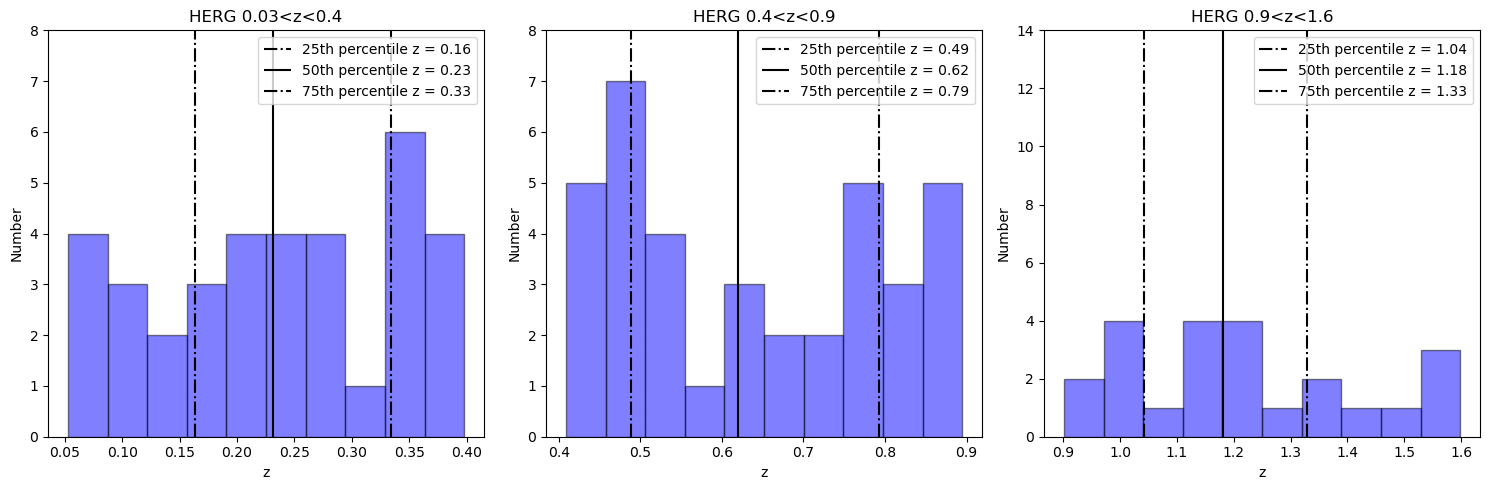

In [156]:



percentile_1 = 25
percentile_2 = 50
percentile_3 = 75
z_cut_1 = np.percentile(my_table_1['Z'], percentile_1)
z_cut_2 = np.percentile(my_table_1['Z'], percentile_2)
z_cut_3 = np.percentile(my_table_1['Z'], percentile_3)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot for my_table_1
axs[0].hist(my_table_1['Z'], bins=10, color='blue', alpha=0.5, edgecolor='black')
axs[0].set_xlabel('z')
axs[0].set_ylabel('Number')
axs[0].set_title(f'{Overall_class} 0.03<z<0.4')
axs[0].vlines(z_cut_1, ymin=0, ymax=14, colors='black', linestyles='-.', label=f'{percentile_1}th percentile z = {z_cut_1:.2f}')
axs[0].vlines(z_cut_2, ymin=0, ymax=14, colors='black', linestyles='-', label=f'{percentile_2}th percentile z = {z_cut_2:.2f}')
axs[0].vlines(z_cut_3, ymin=0, ymax=14, colors='black', linestyles='-.', label=f'{percentile_3}th percentile z = {z_cut_3:.2f}')
axs[0].legend()
axs[0].set_ylim(0, 8)

# Plot for my_table_2
z_cut_1 = np.percentile(my_table_2['Z'], percentile_1)
z_cut_2 = np.percentile(my_table_2['Z'], percentile_2)
z_cut_3 = np.percentile(my_table_2['Z'], percentile_3)

axs[1].hist(my_table_2['Z'], bins=10, color='blue', alpha=0.5, edgecolor='black')
axs[1].set_xlabel('z')
axs[1].set_ylabel('Number')
axs[1].set_title(f'{Overall_class} 0.4<z<0.9')
axs[1].vlines(z_cut_1, ymin=0, ymax=14, colors='black', linestyles='-.', label=f'{percentile_1}th percentile z = {z_cut_1:.2f}')
axs[1].vlines(z_cut_2, ymin=0, ymax=14, colors='black', linestyles='-', label=f'{percentile_2}th percentile z = {z_cut_2:.2f}')
axs[1].vlines(z_cut_3, ymin=0, ymax=14, colors='black', linestyles='-.', label=f'{percentile_3}th percentile z = {z_cut_3:.2f}')
axs[1].legend()
axs[1].set_ylim(0, 8)

# Plot for my_table_3
z_cut_1 = np.percentile(my_table_3['Z'], percentile_1)
z_cut_2 = np.percentile(my_table_3['Z'], percentile_2)
z_cut_3 = np.percentile(my_table_3['Z'], percentile_3)

axs[2].hist(my_table_3['Z'], bins=10, color='blue', alpha=0.5, edgecolor='black')
axs[2].set_xlabel('z')
axs[2].set_ylabel('Number')
axs[2].set_title(f'{Overall_class} 0.9<z<1.6')
axs[2].vlines(z_cut_1, ymin=0, ymax=14, colors='black', linestyles='-.', label=f'{percentile_1}th percentile z = {z_cut_1:.2f}')
axs[2].vlines(z_cut_2, ymin=0, ymax=14, colors='black', linestyles='-', label=f'{percentile_2}th percentile z = {z_cut_2:.2f}')
axs[2].vlines(z_cut_3, ymin=0, ymax=14, colors='black', linestyles='-.', label=f'{percentile_3}th percentile z = {z_cut_3:.2f}')
axs[2].legend()
axs[2].set_ylim(0, 14)

plt.tight_layout()
plt.show()



In [95]:
print(np.min(my_table['Z']))

0.052591297908750466


## Plot Stacked Spectra

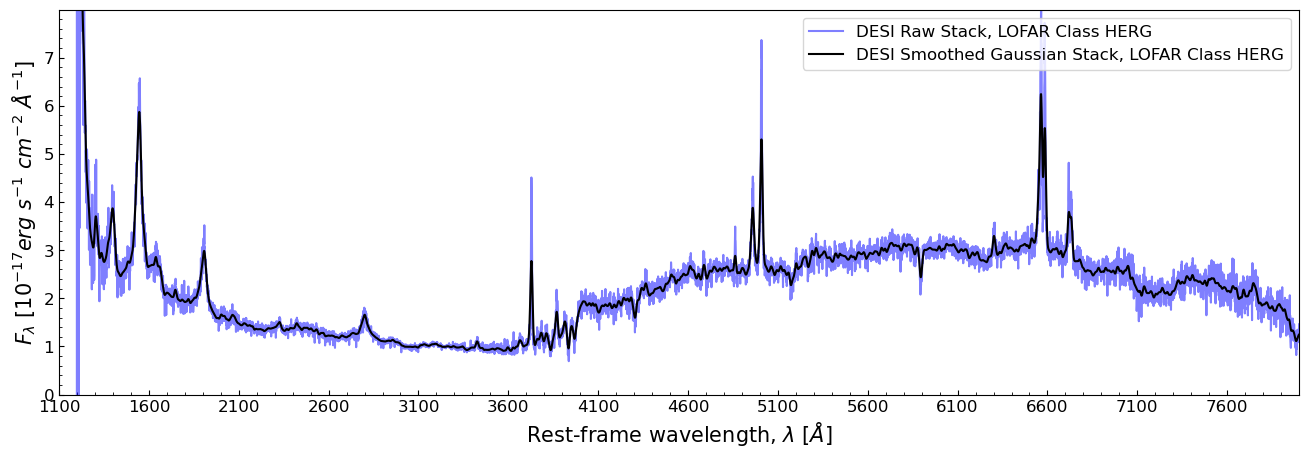

All plots saved in DESI-HERG-stack_NEW.pdf
8526 8526


In [158]:


# Create a PDF file to save the plots
pdf_filename = f'DESI-{Overall_class}-stack_NEW.pdf'
with PdfPages(pdf_filename) as pdf:
        fig, ax = plt.subplots(figsize=(16, 5))
        ax.plot(wln,flux, color='blue', alpha=0.5,label = f'DESI Raw Stack, LOFAR Class {Overall_class}')
        ax.plot(wln,convolve(flux, Gaussian1DKernel(5)), color='black', alpha=1, label = f'DESI Smoothed Gaussian Stack, LOFAR Class {Overall_class}')
        ax.set_ylabel('$F_{\lambda}$ [$10^{-17} erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')
        ax.set_xlabel('Rest-frame wavelength, $\lambda$ [$\AA$]')
        ax.set_xlim(1100,8000)
        ax.set_ylim(0,8)
        ax.set_xticks(range(1100, 8001, 500))
        ax.set_yticks(range(0, 8, 1))
        ax.tick_params(axis='both', which='both', labelsize=12, direction = 'in')
        ax.minorticks_on()
        ax.legend(fontsize='large', loc = 'upper right')
        ax.xaxis.label.set_size(15)
        ax.yaxis.label.set_size(15)

     # Save the current plot to the PDF file
        pdf.savefig(fig)
        plt.show()
        plt.close()

# All the plots will be saved in the PDF file
print(f'All plots saved in {pdf_filename}')





In [159]:
##### NEED TO DECIDE WHAT BINS TO APPLY HERE
#6563
#4861

#?????

def renorm(flux, wln, wln_norm):
    """
    Normalises the flux at a given wavelength
    """
    index_norm = np.abs(wln - wln_norm).argmin()
    print('wln_norm=',wln[index_norm])
    
    flux_norm = flux / flux[index_norm]
    return flux_norm


def renorm(flux, wln, wln_min, wln_max):
    """
    Normalizes the flux to the median wavelength in the specified range
    """
    indices = np.where((wln >= wln_min) & (wln <= wln_max))

    flux_norm = flux / np.median(flux[indices])
    
    return flux_norm

wln_min = 3200
wln_max = 4200

flux_1_norm = renorm(flux_1, wln_1, wln_min, wln_max)
flux_2_norm = renorm(flux_2, wln_2, wln_min, wln_max)
flux_3_norm = renorm(flux_3, wln_3, wln_min, wln_max)
flux_norm = renorm(flux, wln, wln_min, wln_max)





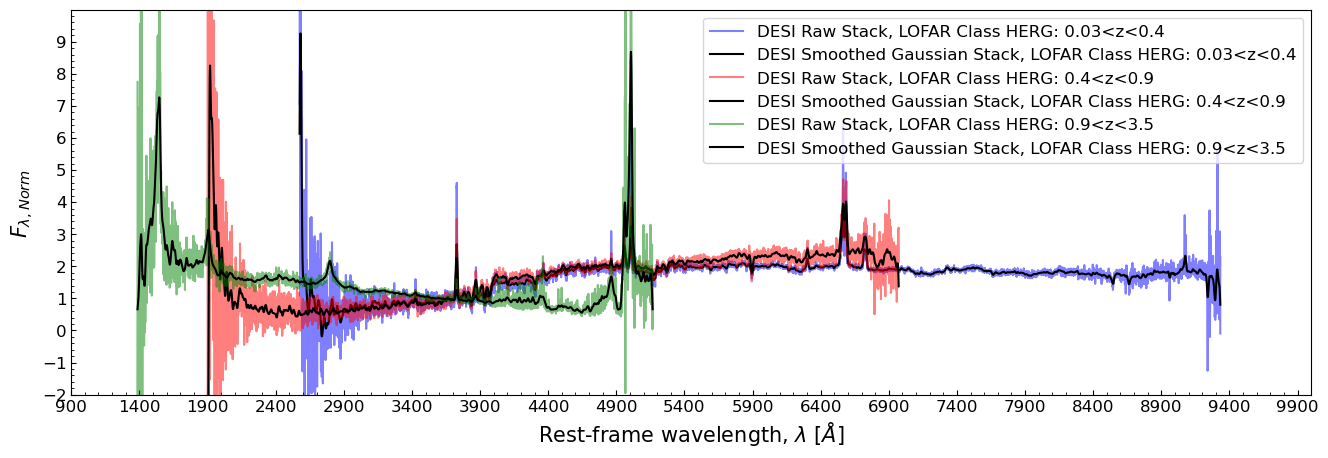

All plots saved in DESI-HERG-stacked-zbin-plots-2.pdf


In [160]:
"""

"""




# Create a PDF file to save the plots
pdf_filename = f'DESI-{Overall_class}-stacked-zbin-plots-2.pdf'
with PdfPages(pdf_filename) as pdf:
        fig, ax = plt.subplots(figsize=(16, 5))
        ax.plot(wln_1,flux_1_norm, label = f'DESI Raw Stack, LOFAR Class {Overall_class}: 0.03<z<0.4', color='blue', alpha=0.5)
        ax.plot(wln_1,convolve(flux_1_norm, Gaussian1DKernel(5)), color='black', alpha=1, label = f'DESI Smoothed Gaussian Stack, LOFAR Class {Overall_class}: 0.03<z<0.4')
        ax.plot(wln_2,flux_2_norm, label = f'DESI Raw Stack, LOFAR Class {Overall_class}: 0.4<z<0.9', color='red', alpha=0.5)
        ax.plot(wln_2,convolve(flux_2_norm, Gaussian1DKernel(5)), color='black', alpha=1, label = f'DESI Smoothed Gaussian Stack, LOFAR Class {Overall_class}: 0.4<z<0.9')
        ax.plot(wln_3,flux_3_norm, label = f'DESI Raw Stack, LOFAR Class {Overall_class}: 0.9<z<3.5', color='green', alpha=0.5)
        ax.plot(wln_3,convolve(flux_3_norm, Gaussian1DKernel(5)), color='black', alpha=1, label = f'DESI Smoothed Gaussian Stack, LOFAR Class {Overall_class}: 0.9<z<3.5')
        ax.set_ylabel('$F_{\lambda, Norm}$ ')
        ax.set_xlabel('Rest-frame wavelength, $\lambda$ [$\AA$]')
        ax.set_xlim(900,10000)
        ax.set_ylim(-2,10)
        ax.set_xticks(range(900, 10001, 500))
        ax.set_yticks(range(-2, 10, 1))
        ax.tick_params(axis='both', which='both', labelsize=12, direction = 'in')
        ax.minorticks_on()
        ax.legend(fontsize='large', loc = 'upper right')
        ax.xaxis.label.set_size(15)
        ax.yaxis.label.set_size(15)

     # Save the current plot to the PDF file
        pdf.savefig(fig)
        plt.show()
        plt.close()

# After the loop, all the plots will be saved in the PDF file
print(f'All plots saved in {pdf_filename}')




In [161]:

"""

Add in some bounds to remove the upper and lower 10% of each spectra as noise reduction

"""

def bounds(stack_array):
        bound = 0.1
        l_bound = len(stack_array)*bound
        u_bound = len(stack_array)-(len(stack_array)*bound)

        return int(l_bound), int(u_bound)


st1 = bounds(wln_1)
st2 = bounds(wln_2)
st3 = bounds(wln_3)




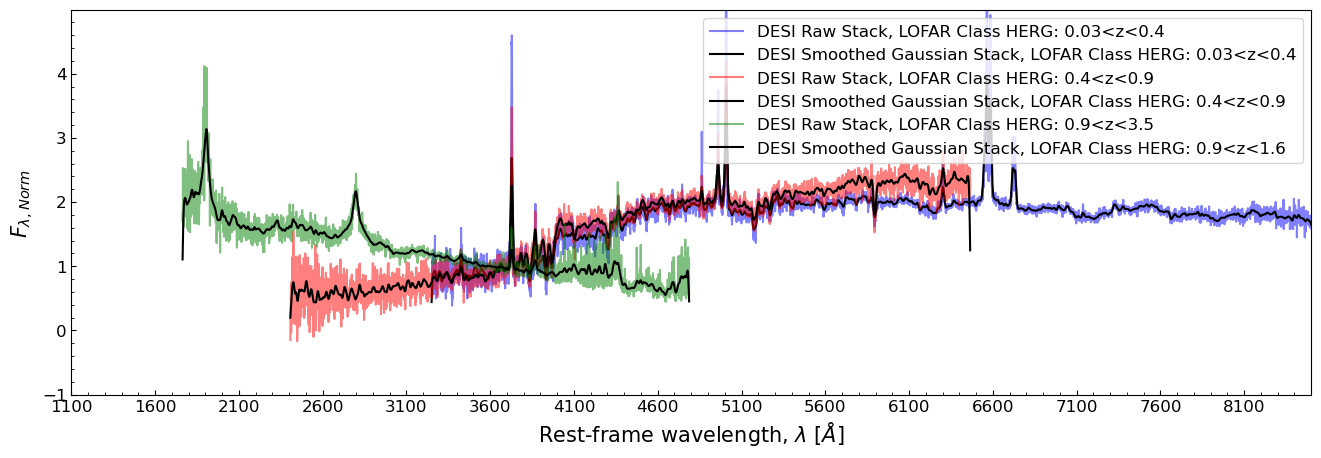

All plots saved in DESI-HERG-stacked-zbin-plots-0.1cut.pdf


In [165]:
# Create a PDF file to save the plots
pdf_filename = f'DESI-{Overall_class}-stacked-zbin-plots-0.1cut.pdf'
with PdfPages(pdf_filename) as pdf:
        fig, ax = plt.subplots(figsize=(16, 5))
        ax.plot(wln_1[st1[0]:st1[1]],flux_1_norm[st1[0]:st1[1]], label = f'DESI Raw Stack, LOFAR Class {Overall_class}: 0.03<z<0.4', color='blue', alpha=0.5)
        ax.plot(wln_1[st1[0]:st1[1]],convolve(flux_1_norm[st1[0]:st1[1]], Gaussian1DKernel(5)), color='black', alpha=1, label = f'DESI Smoothed Gaussian Stack, LOFAR Class {Overall_class}: 0.03<z<0.4')
        ax.plot(wln_2[st2[0]:st2[1]],flux_2_norm[st2[0]:st2[1]], label = f'DESI Raw Stack, LOFAR Class {Overall_class}: 0.4<z<0.9', color='red', alpha=0.5)
        ax.plot(wln_2[st2[0]:st2[1]],convolve(flux_2_norm[st2[0]:st2[1]], Gaussian1DKernel(5)), color='black', alpha=1, label = f'DESI Smoothed Gaussian Stack, LOFAR Class {Overall_class}: 0.4<z<0.9')
        ax.plot(wln_3[st3[0]:st3[1]],flux_3_norm[st3[0]:st3[1]], label = f'DESI Raw Stack, LOFAR Class {Overall_class}: 0.9<z<3.5', color='green', alpha=0.5)
        ax.plot(wln_3[st3[0]:st3[1]],convolve(flux_3_norm[st3[0]:st3[1]], Gaussian1DKernel(5)), color='black', alpha=1, label = f'DESI Smoothed Gaussian Stack, LOFAR Class {Overall_class}: 0.9<z<1.6')
        ax.set_ylabel('$F_{\lambda, Norm}$ ')
        ax.set_xlabel('Rest-frame wavelength, $\lambda$ [$\AA$]')
        ax.set_xlim(1100,8500)
        ax.set_ylim(-1,5)
        ax.set_xticks(range(1100, 8501, 500))
        ax.set_yticks(range(-1, 5, 1))
        ax.tick_params(axis='both', which='both', labelsize=12, direction = 'in')
        ax.minorticks_on()
        ax.legend(fontsize='large', loc = 'upper right')
        ax.xaxis.label.set_size(15)
        ax.yaxis.label.set_size(15)

     # Save the current plot to the PDF file
        pdf.savefig(fig)
        plt.show()
        plt.close()

# After the loop, all the plots will be saved in the PDF file
print(f'All plots saved in {pdf_filename}')

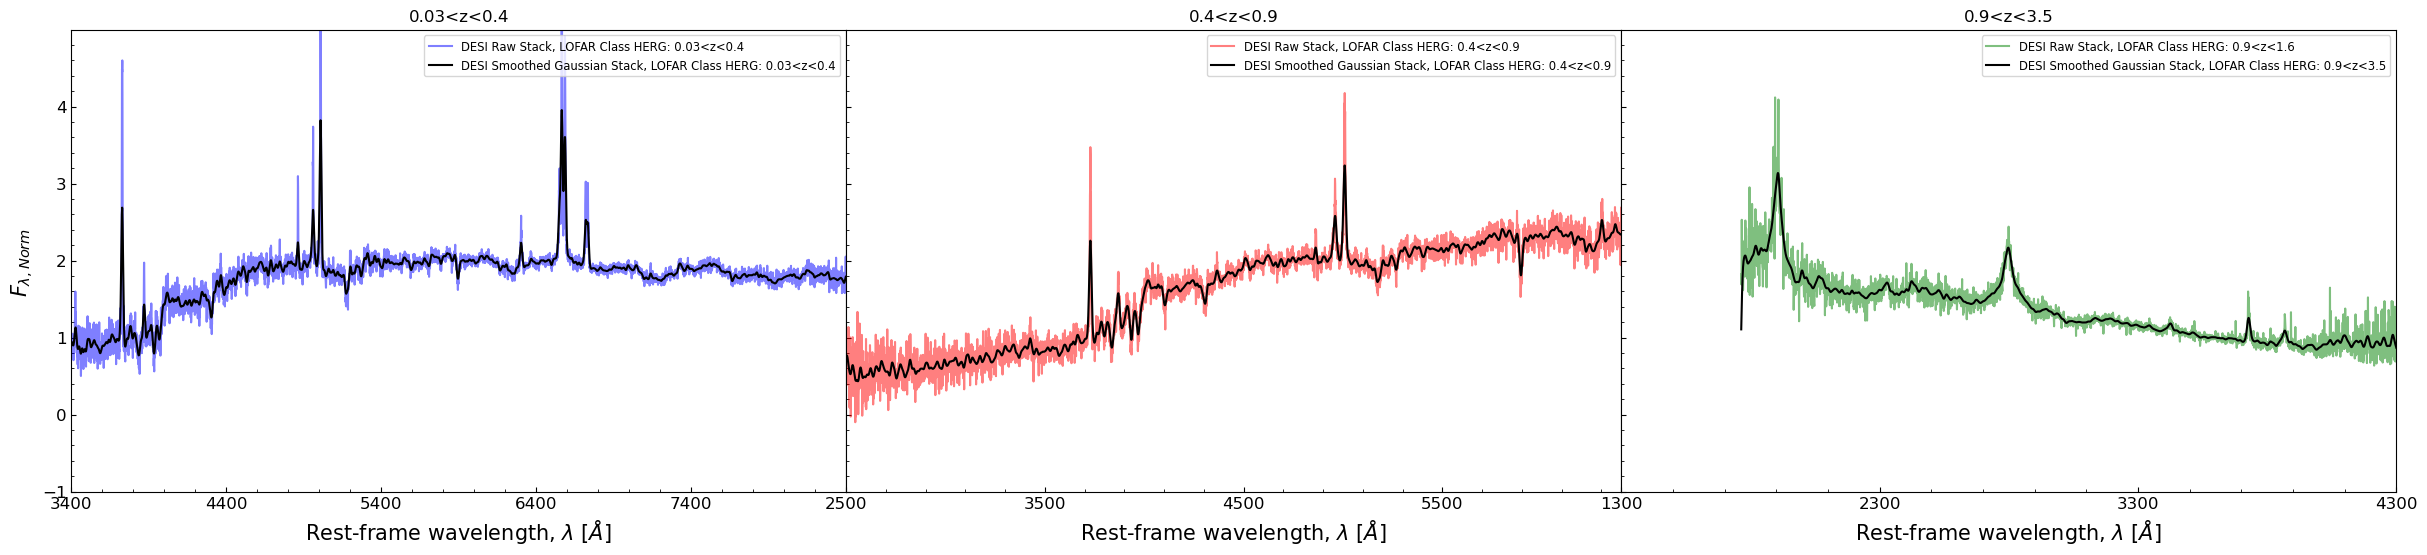

All plots saved in DESI-HERG-stacked-zbin-plots-0.1cut.pdf


In [164]:
#### change the order of the plots to be in order of redshift



# Create a PDF file to save the plots
pdf_filename = f'DESI-{Overall_class}-stacked-zbin-plots-0.1cut.pdf'
with PdfPages(pdf_filename) as pdf:
    # Create a 1x3 grid of subplots with no spacing between plots
    fig, axs = plt.subplots(1, 3, figsize=(30, 6), sharey=True, sharex=False, gridspec_kw={'wspace': 0})
    
    # Plot for column 1 (flux_1)
    axs[0].plot(wln_1[st1[0]:st1[1]], flux_1_norm[st1[0]:st1[1]], label=f'DESI Raw Stack, LOFAR Class {Overall_class}: 0.03<z<0.4', color='blue', alpha=0.5)
    axs[0].plot(wln_1[st1[0]:st1[1]], convolve(flux_1_norm[st1[0]:st1[1]], Gaussian1DKernel(5)), color='black', alpha=1, label=f'DESI Smoothed Gaussian Stack, LOFAR Class {Overall_class}: 0.03<z<0.4')
    axs[0].set_xlim(3400, 8400)
    axs[0].set_xticks(range(3400, 8399, 1000))
    axs[0].set_title('0.03<z<0.4')
    
    # Plot for column 2 (flux_2)
    axs[1].plot(wln_2[st2[0]:st2[1]], flux_2_norm[st2[0]:st2[1]], label=f'DESI Raw Stack, LOFAR Class {Overall_class}: 0.4<z<0.9', color='red', alpha=0.5)
    axs[1].plot(wln_2[st2[0]:st2[1]], convolve(flux_2_norm[st2[0]:st2[1]], Gaussian1DKernel(5)), color='black', alpha=1, label=f'DESI Smoothed Gaussian Stack, LOFAR Class {Overall_class}: 0.4<z<0.9')
    axs[1].set_xlim(2500, 6400)
    axs[1].set_xticks(range(2500, 6401, 1000))
    axs[1].set_title('0.4<z<0.9')

    # Plot for column 3 (flux_3)
    axs[2].plot(wln_3[st3[0]:st3[1]], flux_3_norm[st3[0]:st3[1]], label=f'DESI Raw Stack, LOFAR Class {Overall_class}: 0.9<z<1.6', color='green', alpha=0.5)
    axs[2].plot(wln_3[st3[0]:st3[1]], convolve(flux_3_norm[st3[0]:st3[1]], Gaussian1DKernel(5)), color='black', alpha=1, label=f'DESI Smoothed Gaussian Stack, LOFAR Class {Overall_class}: 0.9<z<3.5')
    axs[2].set_xlim(1300, 4300)
    axs[2].set_xticks(range(1300, 4301, 1000))
    axs[2].set_title('0.9<z<3.5')

    # Customize common settings for all subplots
    for i, ax in enumerate(axs):
        ax.set_ylabel('$F_{\lambda, Norm}$ ')
        ax.set_xlabel('Rest-frame wavelength, $\lambda$ [$\AA$]')
        #ax.set_xlim(1100, 8500)
        ax.set_ylim(-1, 5)
        #ax.set_xticks(range(1100, 8501, 1000))  # Adjust the tick values
        ax.set_yticks(range(-1, 5, 1))
        ax.tick_params(axis='both', which='both', labelsize=12, direction='in')
        ax.minorticks_on()
        if i != 0:
            ax.set_ylabel('')
        ax.legend(fontsize='small', loc='upper right')  # Adjust the legend location
        ax.xaxis.label.set_size(15)
        ax.yaxis.label.set_size(15)

    
    # Save the current plot to the PDF file
    pdf.savefig(fig)
    plt.show()
    plt.close()

# After the loop, all the plots will be saved in the PDF file
print(f'All plots saved in {pdf_filename}')
